Вариант 19 Данные о миллионерах https://www.kaggle.com/datasets/surajjha101/forbes-billionaires-data-preprocessed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv("..//static//csv//Forbes Billionaires.csv")
print(df.columns)

Index(['Rank ', 'Name', 'Networth', 'Age', 'Country', 'Source', 'Industry'], dtype='object')


In [56]:
df.head()

Rank                        Name  Networth  Age        Country  \
0      1                 Elon Musk      144.0   50  United States   
1      2                Jeff Bezos      138.0   58  United States   
2      3  Bernard Arnault & family      133.0   73         France   
3      4                Bill Gates      129.0   66  United States   
4      5            Warren Buffett      118.0   91  United States   

               Source                Industry  
0       Tesla, SpaceX             Automotive   
1              Amazon             Technology   
2                LVMH       Fashion & Retail   
3           Microsoft             Technology   
4  Berkshire Hathaway  Finance & Investments

In [57]:
df.describe()

Rank      Networth          Age
count  2600.000000  2600.000000  2600.000000
mean   1269.570769     4.809596    64.271923
std     728.146364     9.845084    13.220607
min       1.000000     1.000000    19.000000
25%     637.000000     1.500000    55.000000
50%    1292.000000     2.400000    64.000000
75%    1929.000000     4.500000    74.000000
max    2578.000000   144.000000   100.000000

In [58]:
# Процент пропущенных значений признаков
for i in df.columns:
    null_rate = df[i].isnull().sum() / len(df) * 100
    if null_rate > 0:
        print(f'{i} Процент пустых значений: %{null_rate:.2f}')

print(df.isnull().sum())

print(df.isnull().any())

Rank        0
Name        0
Networth    0
Age         0
Country     0
Source      0
Industry    0
dtype: int64
Rank        False
Name        False
Networth    False
Age         False
Country     False
Source      False
Industry    False
dtype: bool


In [59]:
# Проверка типов столбцов
df.dtypes

Rank          int64
Name         object
Networth    float64
Age           int64
Country      object
Source       object
Industry     object
dtype: object

# Атрибуты  

Rank: Рейтинг миллиардера в списке Forbes.

Name: Имя миллиардера.

Networth: Чистая стоимость в миллиардах долларов США.

Age: Возраст миллиардера.

Country: Страна, в которой проживает миллиардер.

Source: Основной источник богатства 

Industry: Индустрия, в которой миллиардер заработал свое состояние.

# Цель:
Оптимизация стратегий инвестирования и маркетинга для финансовых учреждений и компаний, стремящихся привлечь миллиардеров как клиентов или партнеров.
Кластеризация миллиардеров на основе их характеристик (возраст, страна проживания, источник богатства, индустрия) для выявления групп с похожими профилями.

## Очистка данных

Цель: Упростить набор данных, удалив несущественные столбцы, чтобы сосредоточиться на ключевых атрибутах, которые будут использоваться для кластеризации и анализа.
- Rank - этот столбец можно удалить, так как он не влияет на характеристики миллиардера
- Name - этот столбец можно удалить, так как он не является количественным атрибутом

In [60]:
# Удаление несущественных столбцов
columns_to_drop = ['Rank ', 'Name']
df_cleaned = df.drop(columns=columns_to_drop)

print(df_cleaned.head())  # Вывод очищенного DataFrame

   Networth  Age        Country              Source                Industry
0     144.0   50  United States       Tesla, SpaceX             Automotive 
1     138.0   58  United States              Amazon             Technology 
2     133.0   73         France                LVMH       Fashion & Retail 
3     129.0   66  United States           Microsoft             Technology 
4     118.0   91  United States  Berkshire Hathaway  Finance & Investments 


## Визуализация парных взаимосвязей
Визуализировать ключевые атрибуты миллиардеров для выявления закономерностей и связей между ними.

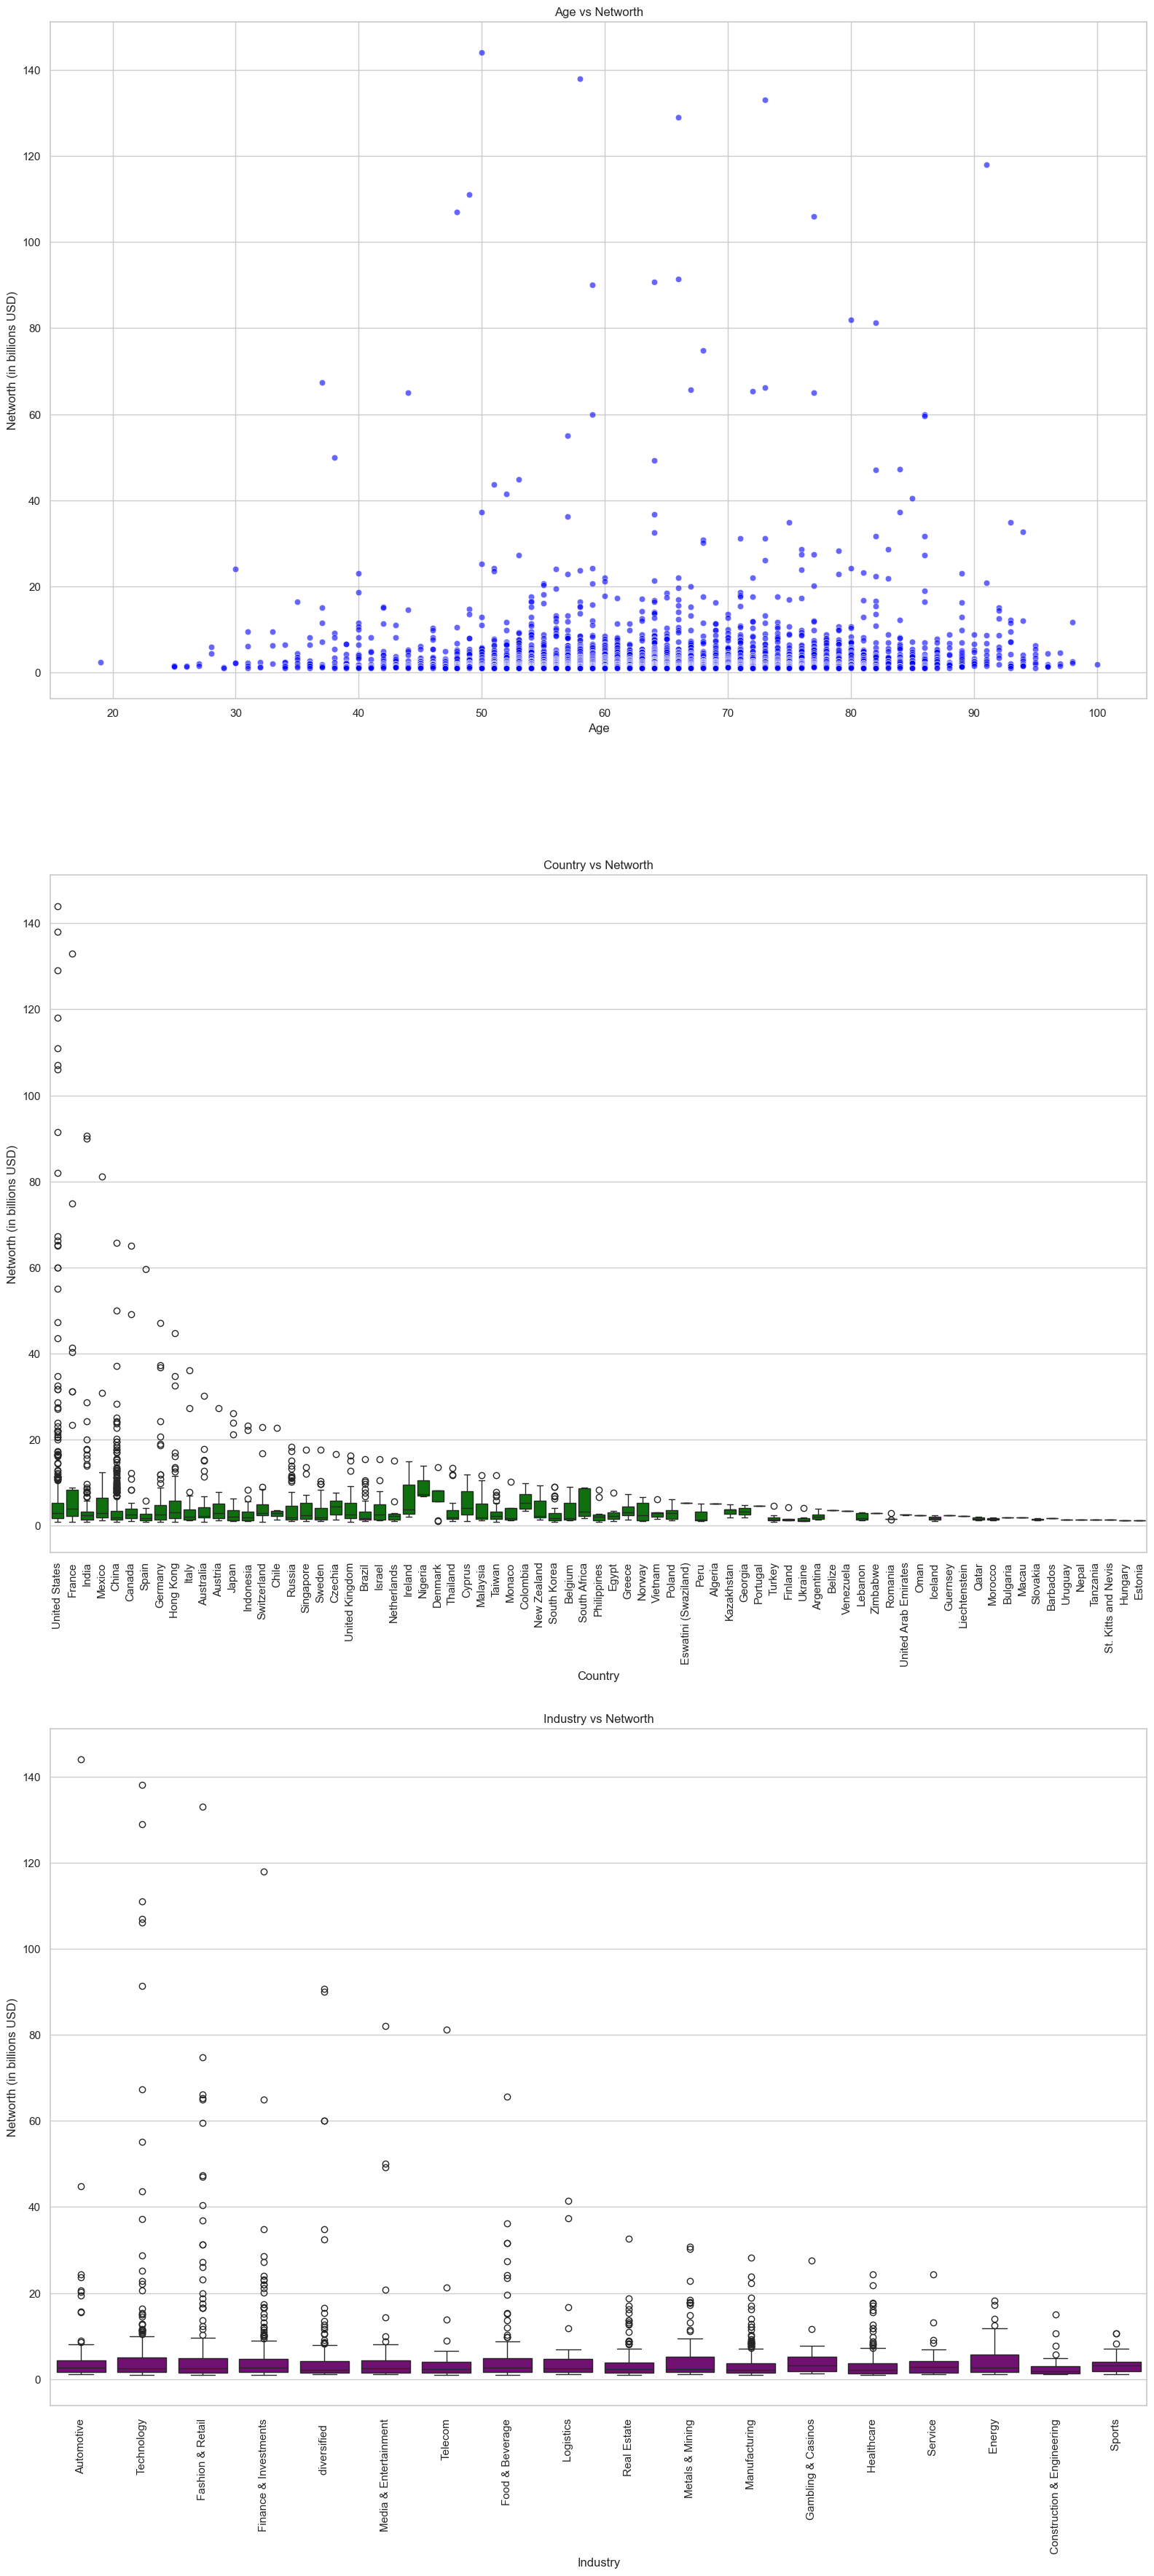

In [64]:
# Настройка стиля графиков
sns.set(style="whitegrid")

# Создание фигуры
plt.figure(figsize=(16, 45))

# График 1: Возраст vs Чистый доход
plt.subplot(4, 1, 1)
sns.scatterplot(x=df_cleaned['Age'], y=df_cleaned['Networth'], alpha=0.6, color='blue')
plt.title('Age vs Networth')
plt.xlabel('Age')
plt.ylabel('Networth (in billions USD)')

# График 2: Страна проживания vs Чистый доход
plt.subplot(4, 1, 2)
sns.boxplot(x=df_cleaned['Country'], y=df_cleaned['Networth'], color='green')
plt.title('Country vs Networth')
plt.xlabel('Country')
plt.ylabel('Networth (in billions USD)')
plt.xticks(rotation=90)

# График 3: Индустрия vs Чистый доход
plt.subplot(4, 1, 3)
sns.boxplot(x=df_cleaned['Industry'], y=df_cleaned['Networth'], color='purple')
plt.title('Industry vs Networth')
plt.xlabel('Industry')
plt.ylabel('Networth (in billions USD)')
plt.xticks(rotation=90)

# Упорядочиваем графики
plt.tight_layout()
plt.show()

### Стандартизация данных для кластеризации

In [71]:
from sklearn.preprocessing import OneHotEncoder

# Выделяем числовые и категориальные признаки
numerical_cols = ['Networth', 'Age']
categorical_cols = ['Country', 'Source', 'Industry']

# Масштабирование числовых признаков
scaler = StandardScaler()
df_numerical_scaled = scaler.fit_transform(df_cleaned[numerical_cols])

# Кодирование категориальных признаков с помощью OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse=False для удобства
encoded_data = encoder.fit_transform(df_cleaned[categorical_cols])

# Создаем новые столбцы для закодированных категориальных признаков
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Объединяем числовые и закодированные категориальные данные
df_encoded = pd.concat([df_cleaned[numerical_cols], encoded_df], axis=1)


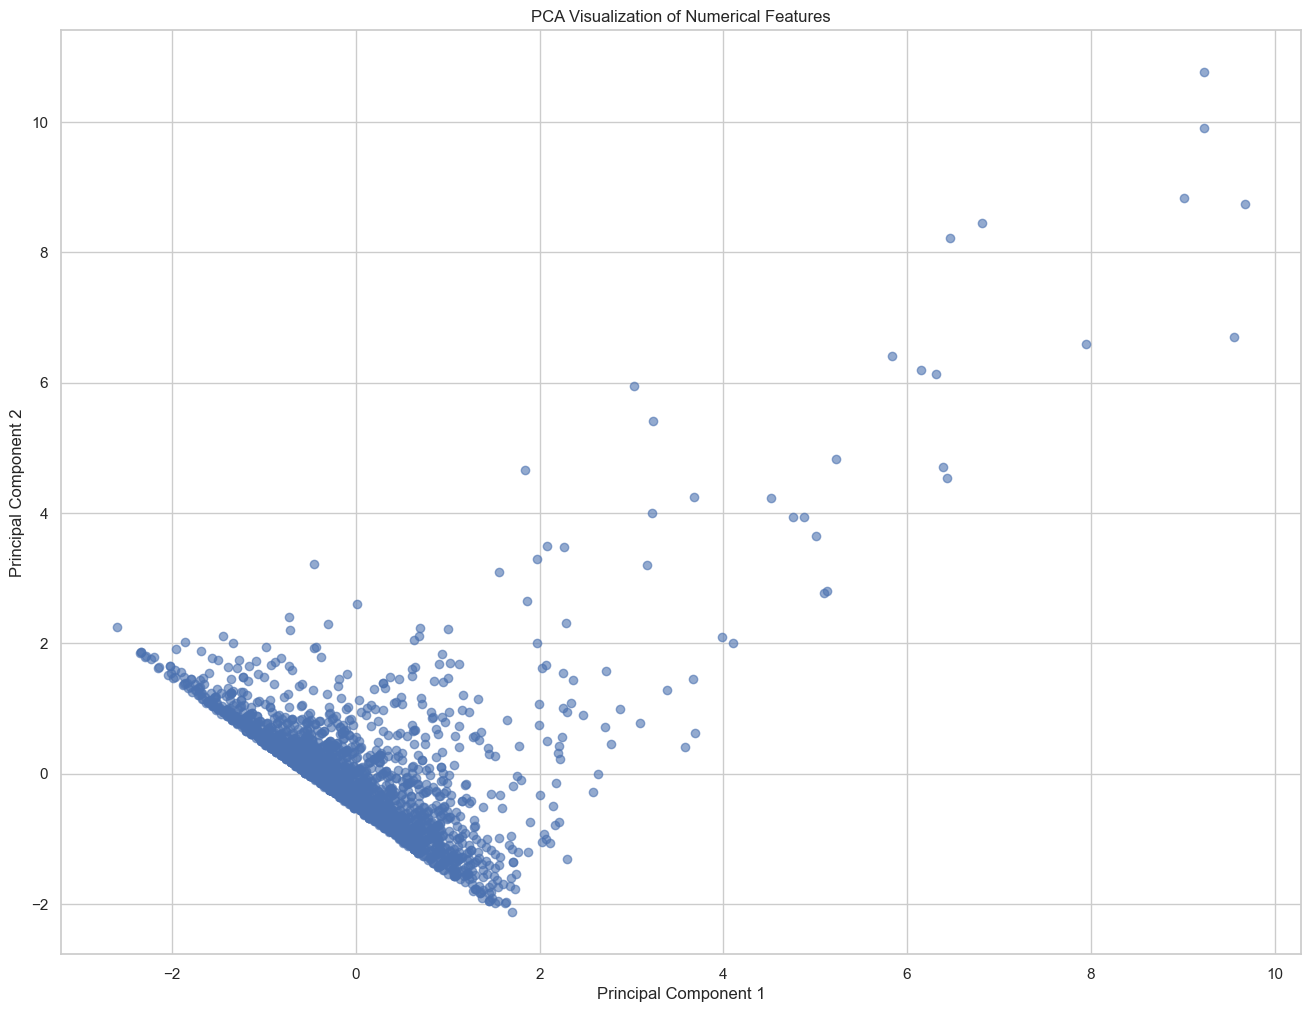

In [73]:
# Применение PCA ТОЛЬКО к числовым данным
pca = PCA(n_components=2)
kc_pca = pca.fit_transform(df_numerical_scaled)

# Визуализация
plt.figure(figsize=(16, 12))
plt.scatter(kc_pca[:, 0], kc_pca[:, 1], alpha=0.6)
plt.title("PCA Visualization of Numerical Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### Агломеративная (иерархическая) кластеризация

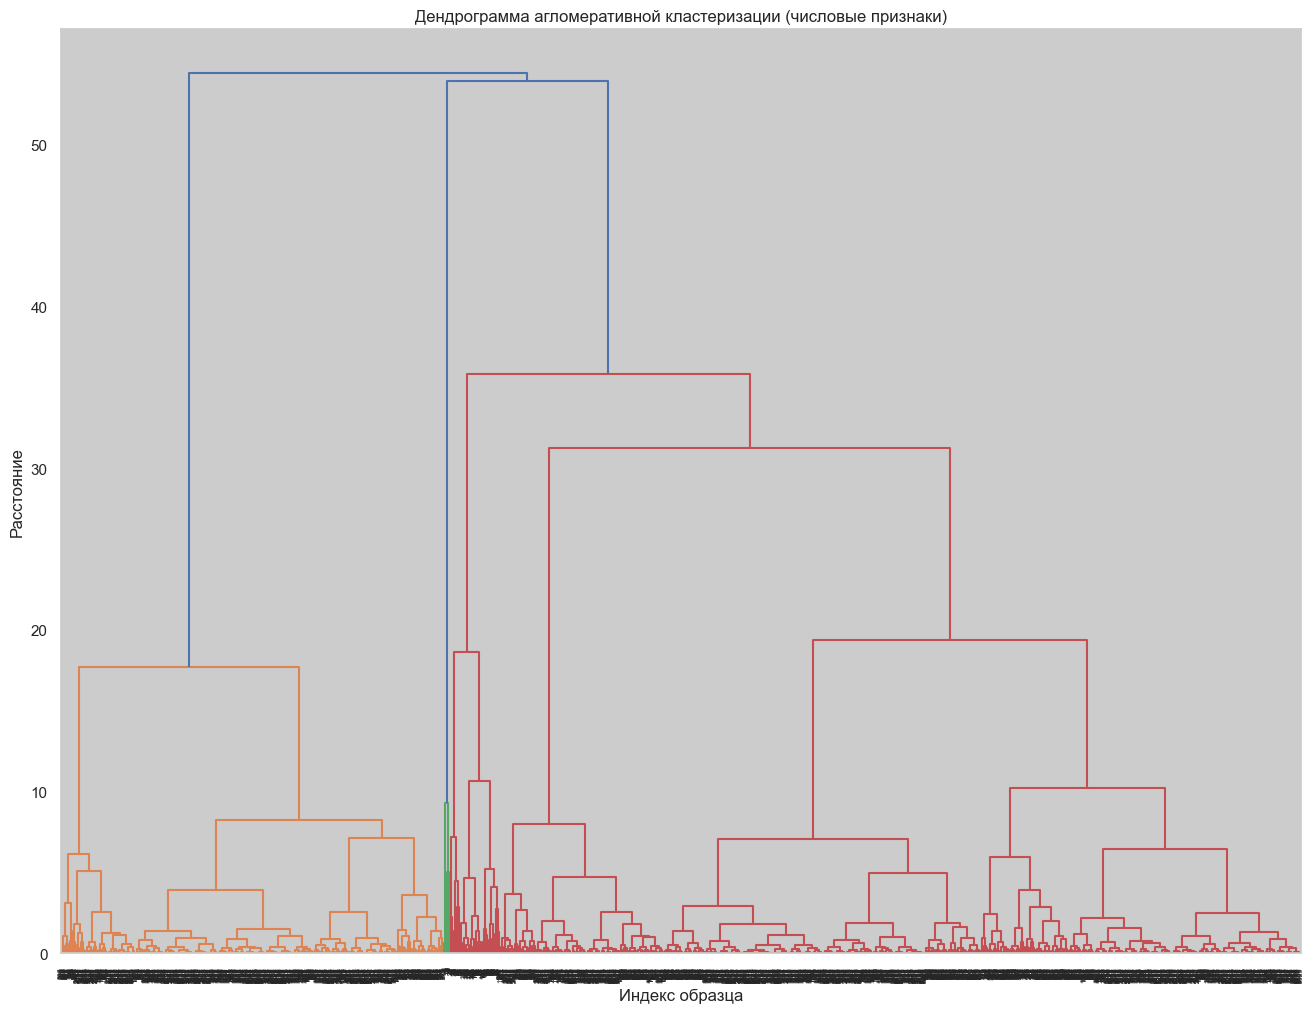

[1 1 1 ... 1 1 1]


In [79]:
# Построение дендрограммы (только для числовых данных)
linkage_matrix = linkage(df_numerical_scaled, method='ward')

plt.figure(figsize=(16, 12))
dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации (числовые признаки)')
plt.xlabel('Индекс образца')
plt.ylabel('Расстояние')
plt.show()

# Получение результатов кластеризации (только для числовых данных)
result = fcluster(linkage_matrix, t=100, criterion='distance') 
print(result) # Вывод результатов кластеризации (номера кластеров для каждого образца)



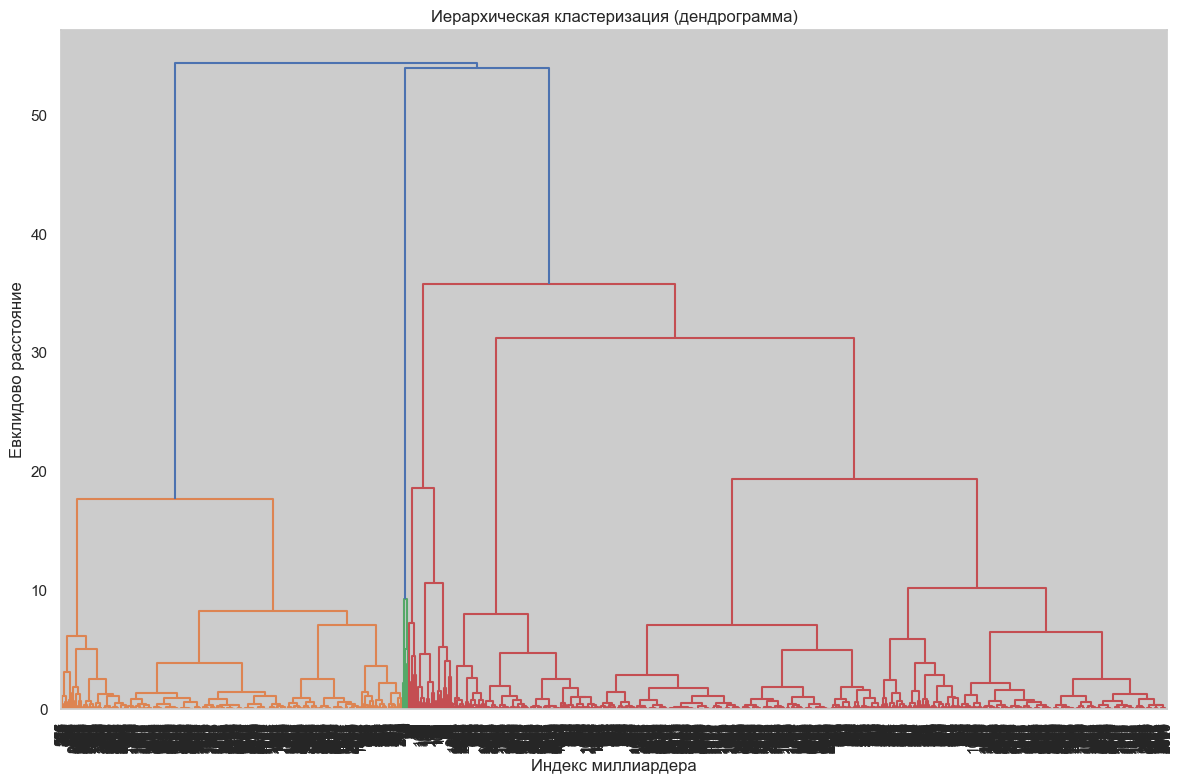

In [82]:
# Выбираем подмножество данных для кластеризации
# у меня всего два числовых столбца мне грустно.....
features = df_encoded[['Networth', 'Age']]

scaled_features = scaler.fit_transform(features)

# Построение дендрограммы
linkage_matrix = linkage(scaled_features, method='ward') 

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Иерархическая кластеризация (дендрограмма)')
plt.xlabel('Индекс миллиардера')
plt.ylabel('Евклидово расстояние')
plt.tight_layout()
plt.show()

**Визуализация распределения кластеров**

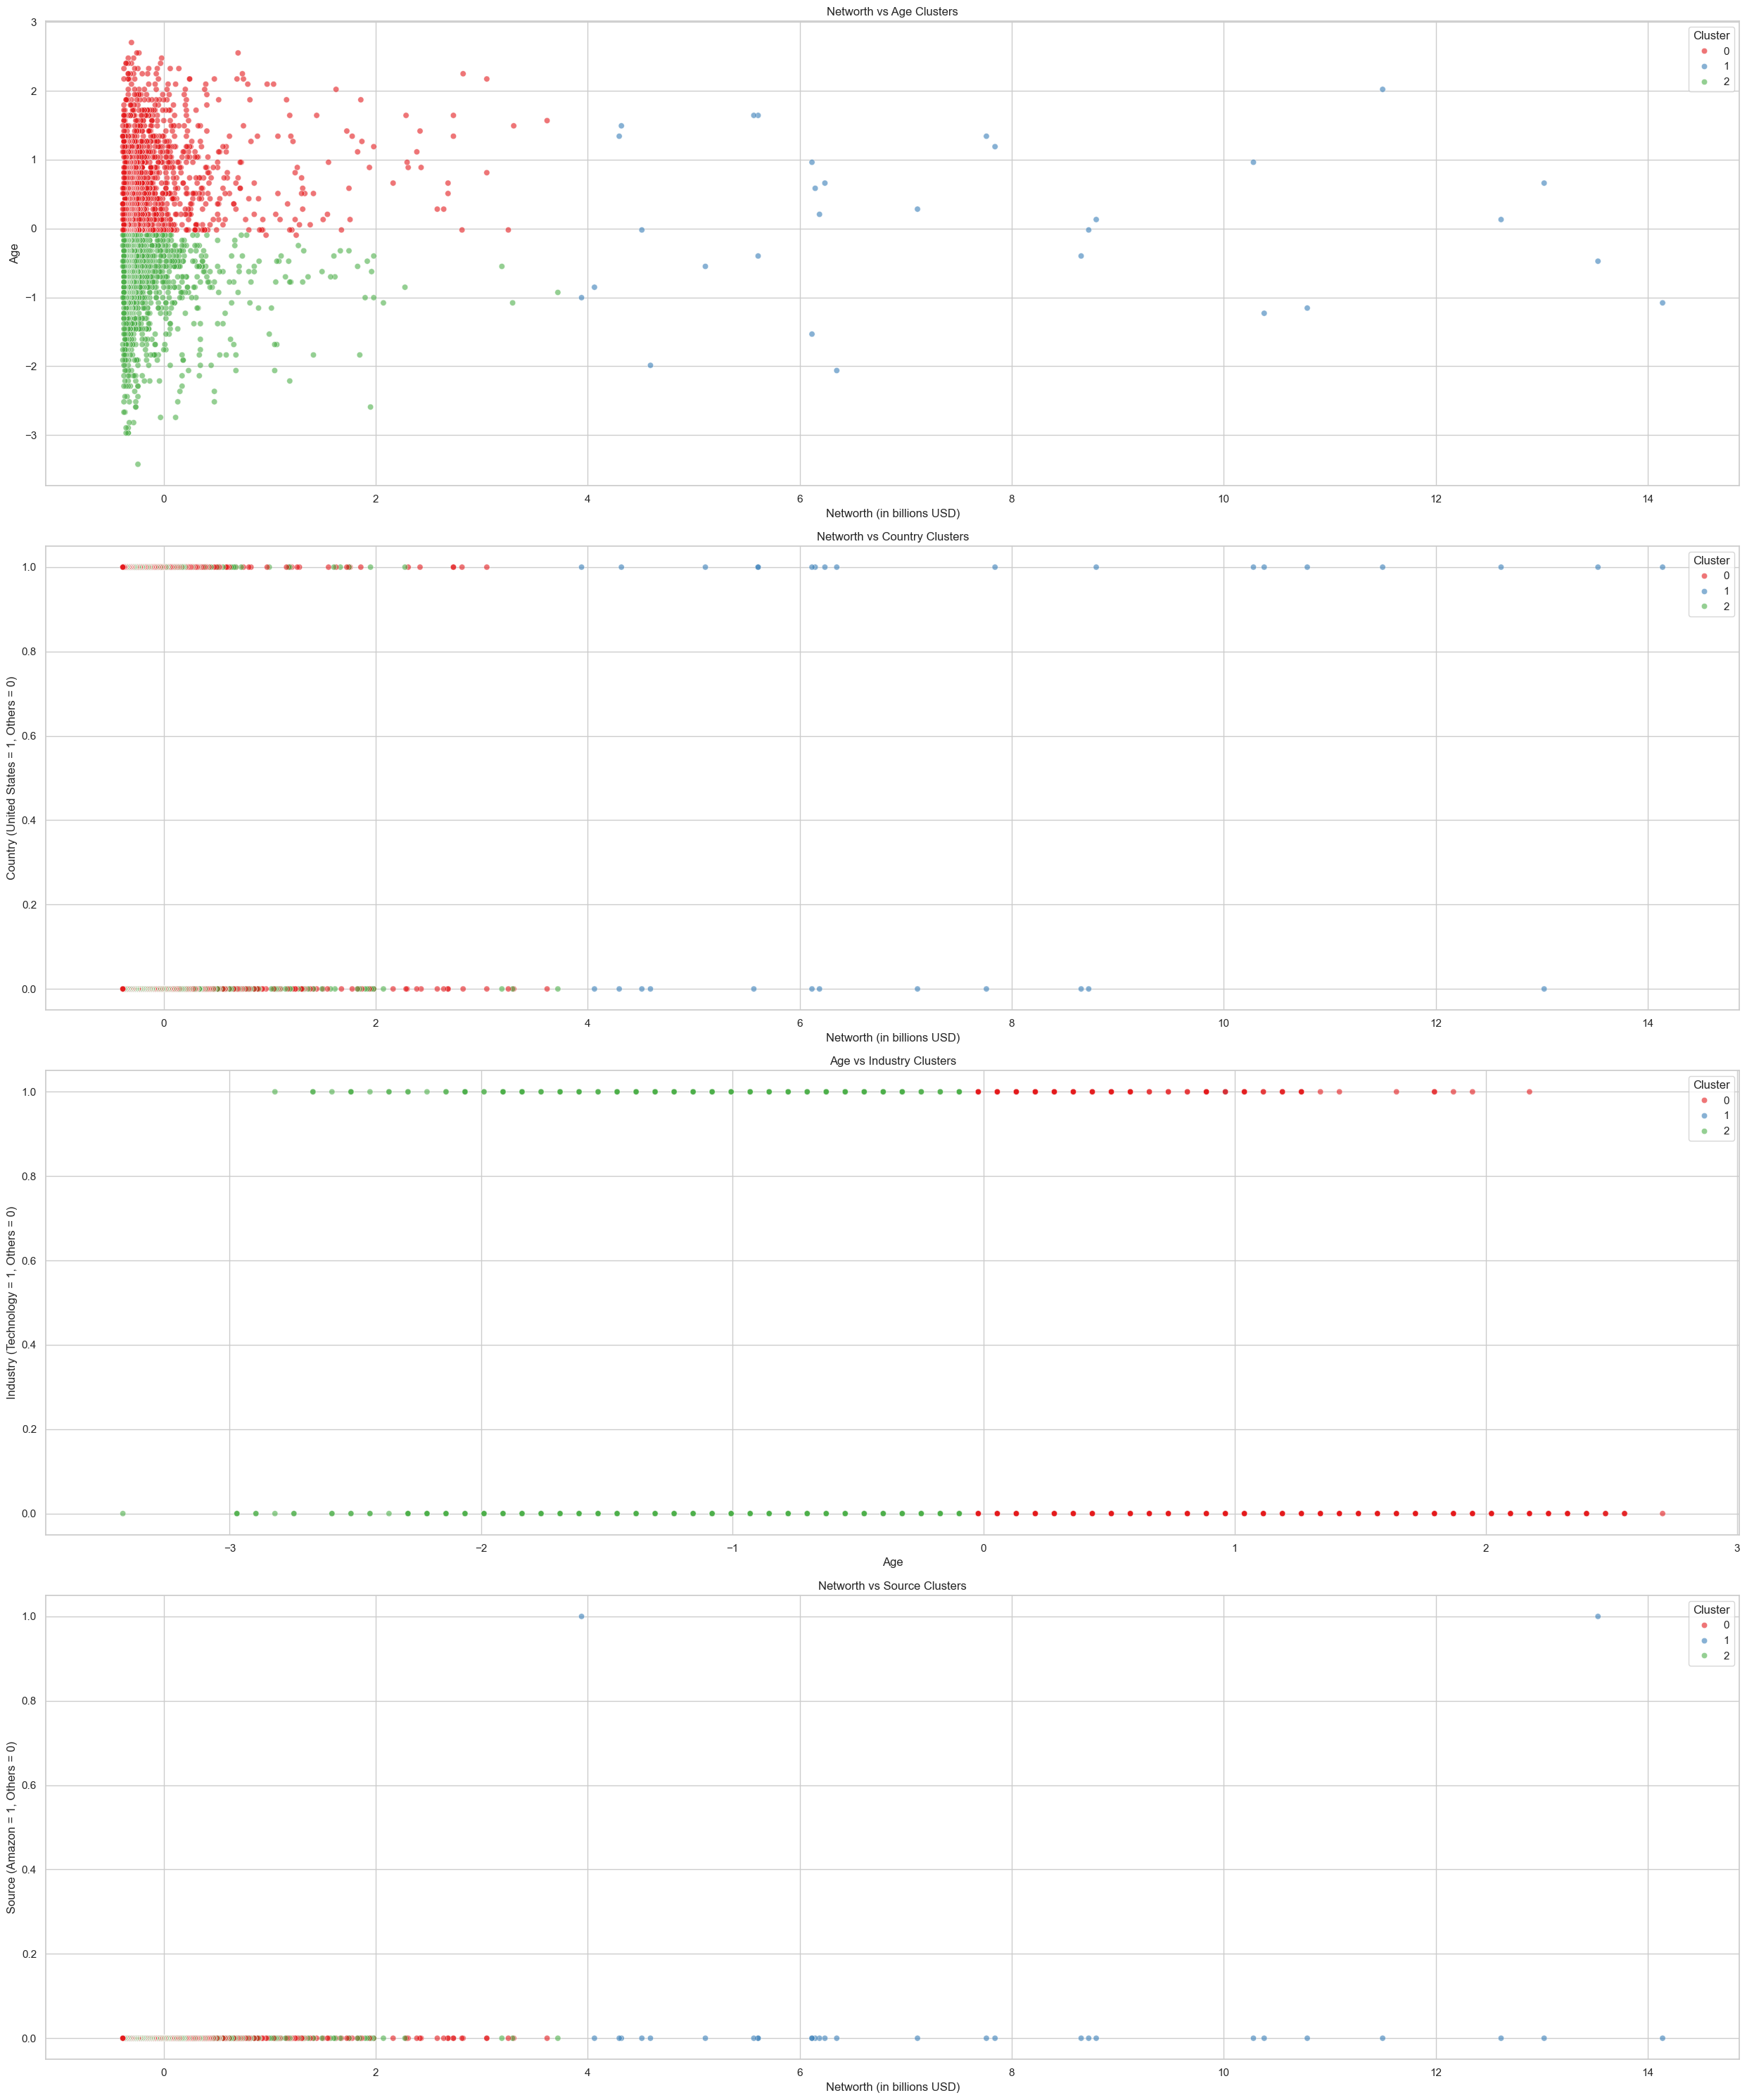

In [103]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Закодирование категориальных переменных
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

# Выбор подмножества данных для кластеризации
features = df_encoded[['Networth', 'Age']]

# Масштабирование данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Кластеризация данных
kmeans = KMeans(n_clusters=3)
df_encoded['Cluster'] = kmeans.fit_predict(scaled_features)

# Визуализация кластеров
plt.figure(figsize=(25, 30))

# Парный график 1: Networth vs Age
plt.subplot(4, 1, 1)
sns.scatterplot(x=df_encoded['Networth'], y=df_encoded['Age'], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
plt.title('Networth vs Age Clusters')
plt.xlabel('Networth (in billions USD)')
plt.ylabel('Age')

# Парный график 2: Networth vs Country
plt.subplot(4, 1, 2)
sns.scatterplot(x=df_encoded['Networth'], y=df_encoded['Country_United States'], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
plt.title('Networth vs Country Clusters')
plt.xlabel('Networth (in billions USD)')
plt.ylabel('Country (United States = 1, Others = 0)')

# Парный график 3: Age vs Industry
plt.subplot(4, 1, 3)
sns.scatterplot(x=df_encoded['Age'], y=df_encoded['Industry_Technology '], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
plt.title('Age vs Industry Clusters')
plt.xlabel('Age')
plt.ylabel('Industry (Technology = 1, Others = 0)')

# Парный график 4: Networth vs Source
plt.subplot(4, 1, 4)
sns.scatterplot(x=df_encoded['Networth'], y=df_encoded['Source_Amazon'], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
plt.title('Networth vs Source Clusters')
plt.xlabel('Networth (in billions USD)')
plt.ylabel('Source (Amazon = 1, Others = 0)')

# Настройка графиков
plt.tight_layout()
plt.show()

## KMeans (неиерархическая кластеризация) для сравнения

Центры кластеров:
 [[ 4.6469914  80.60315186]
 [ 3.49202201 48.5914718 ]
 [80.24333333 65.36666667]
 [ 3.76886463 64.24366812]]


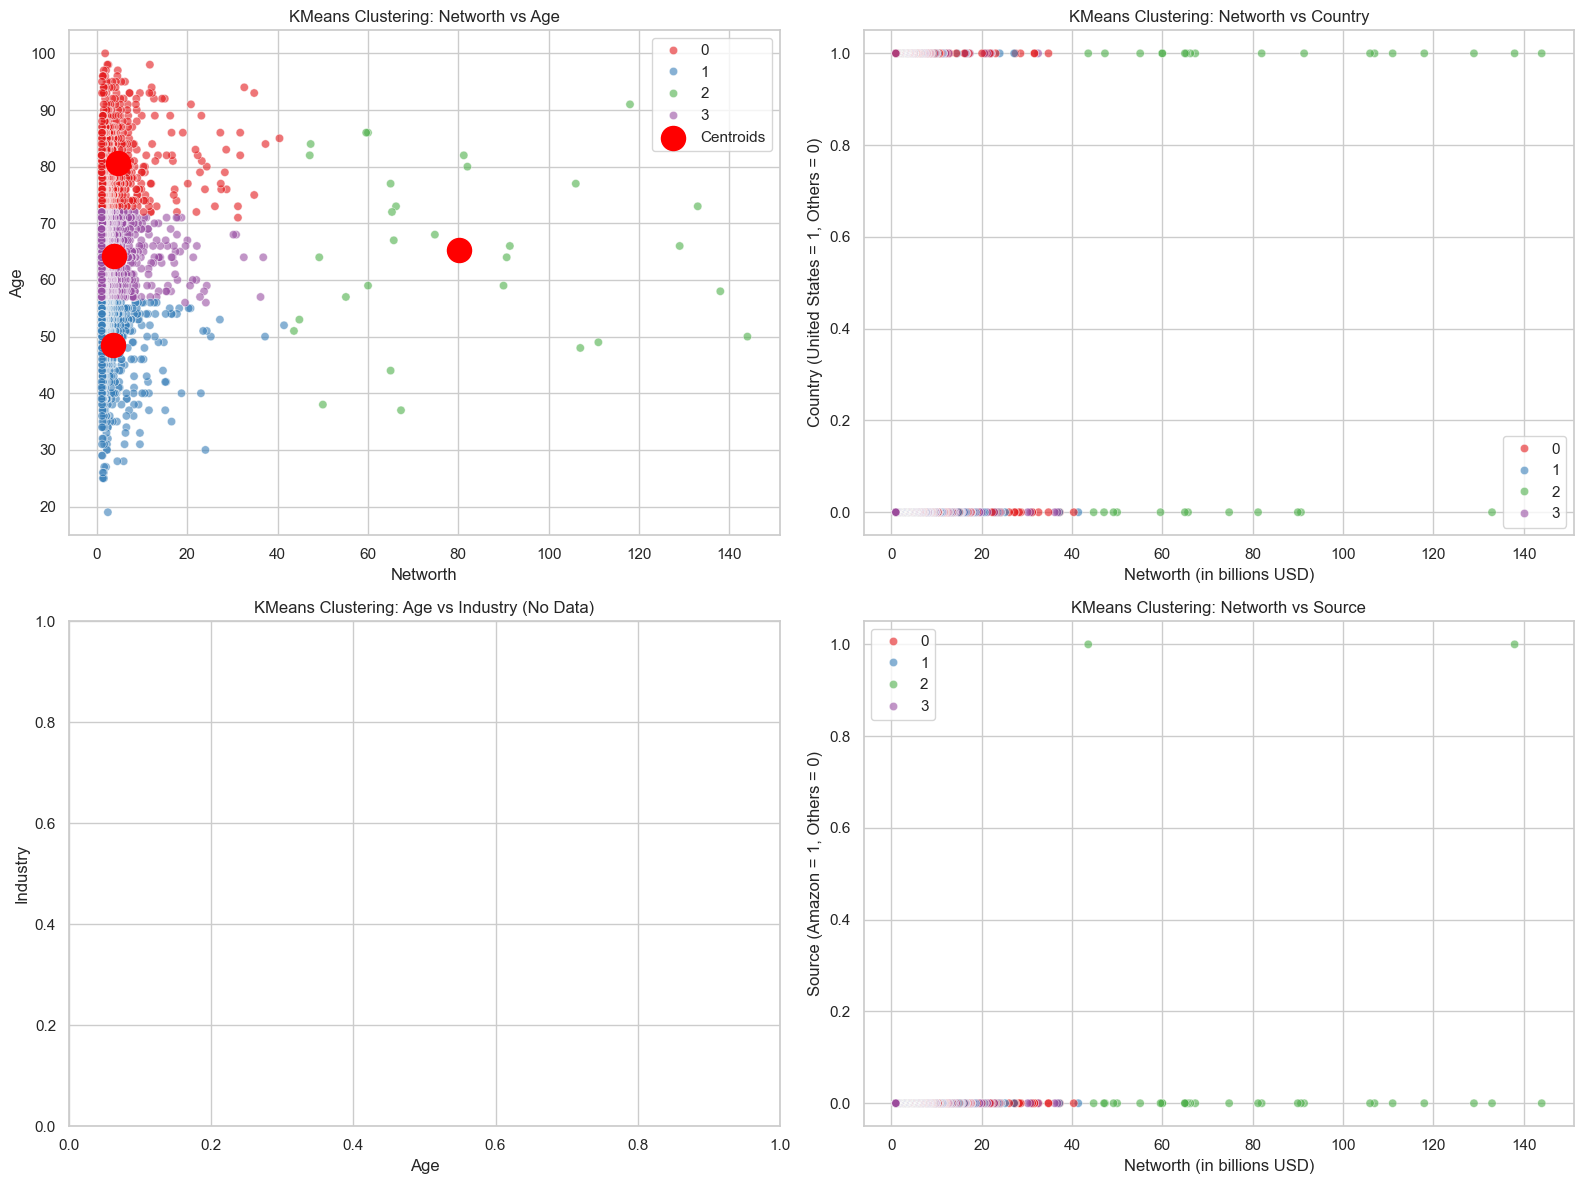

In [107]:
df = pd.read_csv("..//static//csv//Forbes Billionaires.csv")

# Удаление несущественных столбцов
columns_to_drop = ['Rank ', 'Name']
df_cleaned = df.drop(columns=columns_to_drop)

# Закодирование категориальных переменных
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

# Выбор подмножества данных для кластеризации
features_used = ['Networth', 'Age']
data_to_scale = df_encoded[features_used]

# Масштабирование данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_scale)

# Кластеризация данных
random_state = 42
kmeans = KMeans(n_clusters=4, random_state=random_state)
labels = kmeans.fit_predict(data_scaled)
centers = kmeans.cluster_centers_

# Отображение центроидов
centers_original = scaler.inverse_transform(centers)  # Обратная стандартизация
print("Центры кластеров:\n", centers_original)

# Визуализация результатов кластеризации KMeans
plt.figure(figsize=(16, 12))

# Парный график 1: Networth vs Age
plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['Networth'], y=df_cleaned['Age'], hue=labels, palette='Set1', alpha=0.6)
plt.scatter(centers_original[:, 0], centers_original[:, 1], s=300, c='red', label='Centroids')
plt.title('KMeans Clustering: Networth vs Age')
plt.legend()

# Парный график 2: Networth vs Country
plt.subplot(2, 2, 2)
if 'Country_United States' in df_encoded.columns:
    sns.scatterplot(x=df_cleaned['Networth'], y=df_encoded['Country_United States'], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: Networth vs Country')
    plt.xlabel('Networth (in billions USD)')
    plt.ylabel('Country (United States = 1, Others = 0)')
else:
    plt.title('KMeans Clustering: Networth vs Country (No Data)')
    plt.xlabel('Networth (in billions USD)')
    plt.ylabel('Country')

# Парный график 3: Age vs Industry
plt.subplot(2, 2, 3)
if 'Industry_Technology' in df_encoded.columns:
    sns.scatterplot(x=df_cleaned['Age'], y=df_encoded['Industry_Technology'], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: Age vs Industry')
    plt.xlabel('Age')
    plt.ylabel('Industry (Technology = 1, Others = 0)')
else:
    plt.title('KMeans Clustering: Age vs Industry (No Data)')
    plt.xlabel('Age')
    plt.ylabel('Industry')

# Парный график 4: Networth vs Source
plt.subplot(2, 2, 4)
if 'Source_Amazon' in df_encoded.columns:
    sns.scatterplot(x=df_cleaned['Networth'], y=df_encoded['Source_Amazon'], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: Networth vs Source')
    plt.xlabel('Networth (in billions USD)')
    plt.ylabel('Source (Amazon = 1, Others = 0)')
else:
    plt.title('KMeans Clustering: Networth vs Source (No Data)')
    plt.xlabel('Networth (in billions USD)')
    plt.ylabel('Source')

# Настройка графиков
plt.tight_layout()
plt.show()

### PCA для визуализации сокращенной размерности

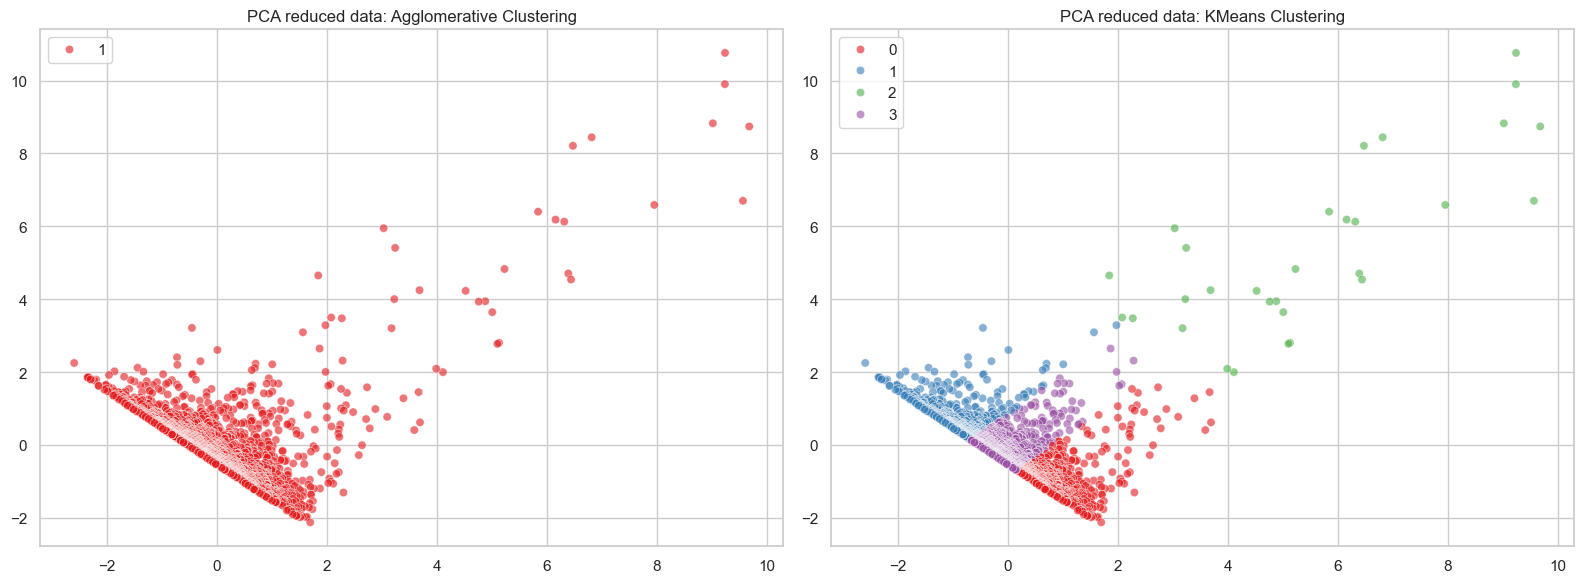

In [108]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled)

# Визуализация сокращенных данных
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=result, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: Agglomerative Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: KMeans Clustering')

plt.tight_layout()
plt.show()

### Анализ инерции для метода локтя (метод оценки суммы квадратов расстояний)

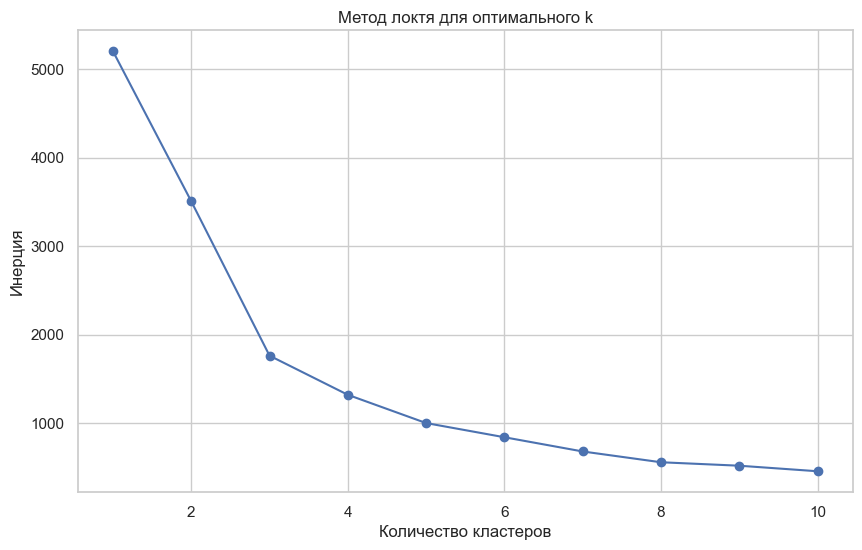

In [109]:
inertias = []
clusters_range = range(1, 11)
for i in clusters_range:
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o')
plt.title('Метод локтя для оптимального k')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

### Расчет коэффициентов силуэта

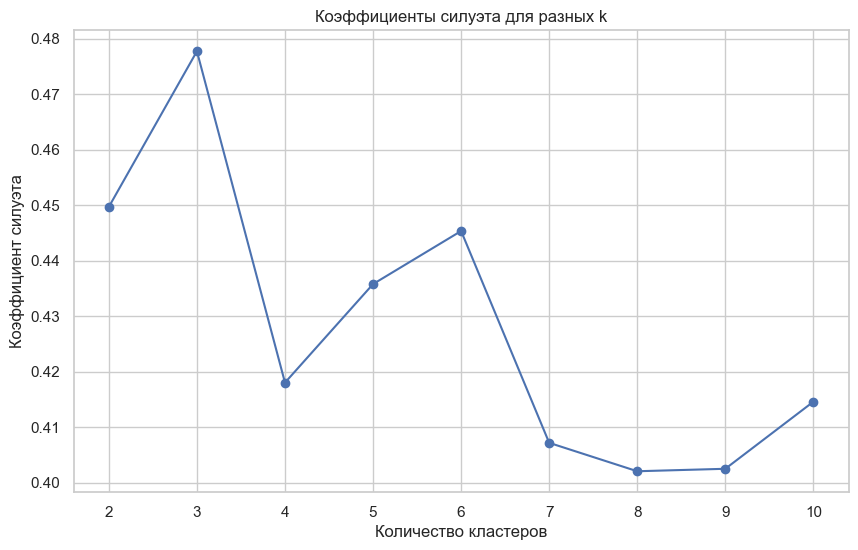

In [110]:
silhouette_scores = []
for i in clusters_range[1:]:  
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Построение диаграммы значений силуэта
plt.figure(figsize=(10, 6))
plt.plot(clusters_range[1:], silhouette_scores, marker='o')
plt.title('Коэффициенты силуэта для разных k')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

Средний коэффициент силуэта: 0.478


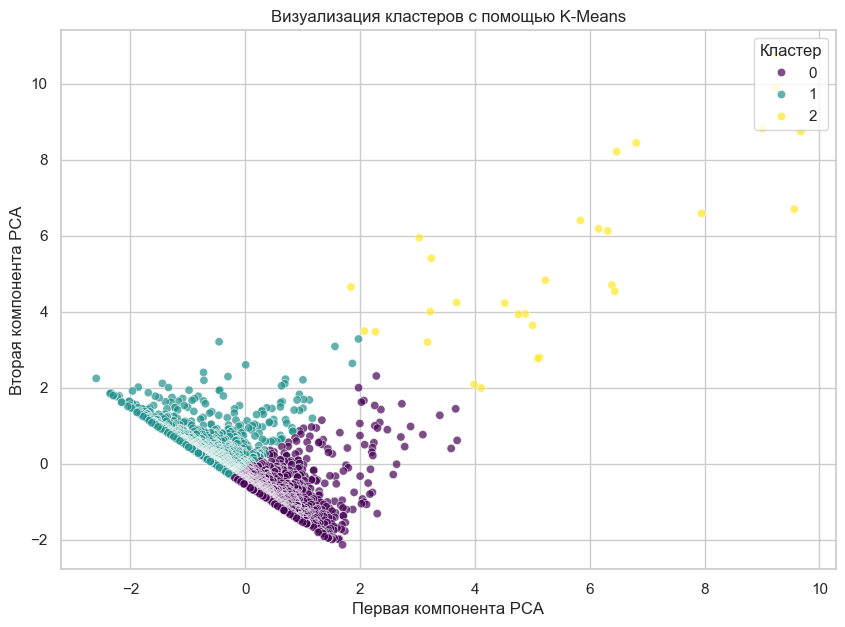

In [ ]:
from sklearn.metrics import silhouette_score
# ========================
# Применение K-Means
# ========================
kmeans = KMeans(n_clusters=3, random_state=42)  
df_clusters = kmeans.fit_predict(data_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg = silhouette_score(data_scaled, df_clusters)
print(f'Средний коэффициент силуэта: {silhouette_avg:.3f}')

# ========================
# Визуализация кластеров
# ========================
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_clusters, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью K-Means')
plt.xlabel('Первая компонентa PCA')
plt.ylabel('Вторая компонентa PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Средний коэффициент силуэта, равный 0.478, указывает на хорошую кластеризацию.  

Средний коэффициент силуэта (silhouette score) указывает на качество кластеризации, измеряя, насколько хорошо точки внутри одного кластера близки друг к другу по сравнению с точками из других кластеров. Значения коэффициента силуэта находятся в диапазоне от -1 до 1:

1: Указывает на идеально плотные и четко разделенные кластеры.  
0: Указывает на перекрытие кластеров или слабую структуру кластеризации.  
Отрицательные значения: Указывают, что точки в кластере расположены ближе к другому кластеру, чем к своему.

Средний коэффициент силуэта (агломеративная кластеризация): 0.409


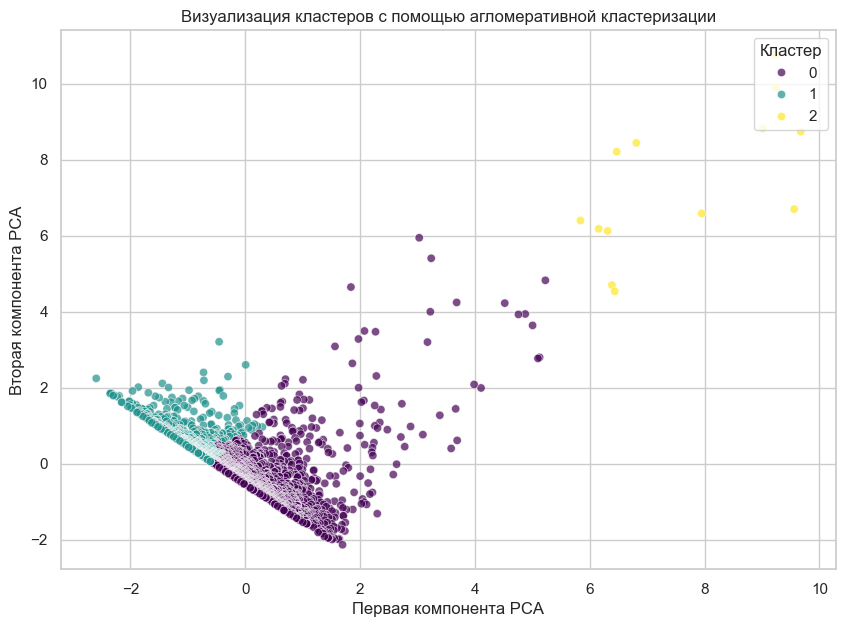

In [112]:
from sklearn.cluster import AgglomerativeClustering

# ========================
# Агломеративная кластеризация
# ========================
agg_cluster = AgglomerativeClustering(n_clusters=3)  
labels_agg = agg_cluster.fit_predict(data_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg_agg = silhouette_score(data_scaled, labels_agg)
print(f'Средний коэффициент силуэта (агломеративная кластеризация): {silhouette_avg_agg:.3f}')

# ========================
# Визуализация кластеров
# ========================
pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=labels_agg, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью агломеративной кластеризации')
plt.xlabel('Первая компонентa PCA')
plt.ylabel('Вторая компонентa PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Значение коэффициента силуэта лежит в диапазоне от -1 до 1. Ближе к 1: Хорошо сформированные, плотные кластеры, четко отделенные друг от друга.  

Ближе к 0: Кластеры пересекаются или слабо разделены, не имеют четких границ. Точки расположены одинаково близко как к своему кластеру, так и к соседним. 
Ближе к -1 (Отрицательные значения): Некоторые точки скорее относятся к другим кластерам, чем к текущему (ближе к центрам других кластеров). Очень плохая кластеризация.  
Ближе к 1: Все точки внутри каждого кластера плотно сгруппированы и значительно удалены от точек других кластеров. Свидетельствует о четкой и хорошо разделенной структуре данных. Единица говорит об идеальной кластеризации.

Средний коэффициент силуэта, равный 0.409, указывает на то, что кластеры имеют умеренно хорошее разделение, но могут иметь нечеткие границы и неоптимальный выбор числа кластеров. Это может быть связано с особенностями данных, затрудняющими их разделение.